In [30]:
import os
import librosa
import glob
from functools import partial

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
from tqdm.notebook import tqdm

from src.modules.training.datasets.to_2d.spec import Spec
from src.modules.training.datasets.to_2d.spec_normalize import SpecNormalize

In [31]:
output_path = '../data/raw/2024/background/'
img_shape = (224 ,224)

In [32]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [33]:
def to_spec(arr):
    # convert numpy array of 5 sec audio to spectrogram
    cls = Spec(spec=partial(torchaudio.transforms.MelSpectrogram), output_shape=img_shape, scale=SpecNormalize(eps=1e-8), sequence_length=160000)

    # to tensor
    t = torch.tensor(arr)
    t = cls(t)
    return t.numpy()

In [34]:
def load_audio(path, length=32000*5, duration=5):
    audio = librosa.load(path, sr=32000, dtype=np.float32, duration=duration)[0]
    if length is None:
        return audio
    if len(audio) < length:
        audio = np.pad(audio, (0, length - len(audio)))
    return audio[:length]

In [35]:
# Get mean background signature
sample_size = 1000
seed = 42
np.random.seed(seed)
src_files = glob.glob('../data/raw/2024/train_audio/*/*.ogg')
src_files = np.random.choice(src_files, sample_size, replace=False)
src_audio = [load_audio(file) for file in tqdm(src_files)]
src_spec = [to_spec(audio) for audio in src_audio]

  0%|          | 0/1000 [00:00<?, ?it/s]

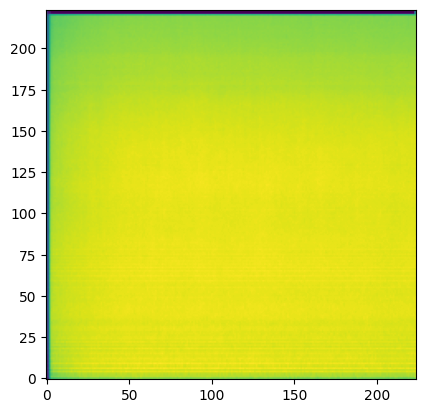

In [36]:
src_mean = np.median(src_spec,axis=0)
plt.imshow(src_mean, origin='lower')
plt.show()

In [37]:
np.save(os.path.join(output_path, 'source.npy'), src_mean)

In [38]:
# Get mean target signature
# sample_size = 1000
seed = 42
np.random.seed(seed)
tgt_files = glob.glob('../data/raw/2024/unlabeled_soundscapes/*.ogg')
tgt_files.sort()

In [39]:
# Get the median across 5 sec segments per file for target
SEG_LEN = 32000*5
MAX_SEG = 20
medians = []
for file in tqdm(tgt_files):
    audio = load_audio(file, length=None, duration=MAX_SEG*5)
    if len(audio) < SEG_LEN:
        continue
    specs = []
    for i in range(0,len(audio),SEG_LEN):
        seg = audio[i:i+SEG_LEN]
        if len(seg) < SEG_LEN:
            break
        specs.append(to_spec(seg))
    median = np.median(specs,axis=0)
    medians.append(median)     

  0%|          | 0/8444 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# plot the first 10
for i in range(3):
    plt.imshow(medians[i], origin='lower')
    plt.show()

In [ ]:
for i, median in enumerate(medians):
    np.save(os.path.join(output_path, f'target_{i}.npy'), median)